In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn import model_selection, metrics
import pickle
import random

In [2]:
dataPaths = os.listdir('ipl_csv2')
all_df = pd.read_csv(os.path.join(os.getcwd(), 'ipl_csv2', 'all_matches.csv'), index_col='match_id')
dataPaths.pop(len(dataPaths) - 2)
dataPaths.pop(len(dataPaths) - 1)

def match_history(p_team, opp_team):

    match_indices = all_df.loc[(all_df['batting_team'] == p_team) | (all_df['bowling_team'] == p_team)].index.unique()

    req_df = []
    
    for match_file in match_indices:
        match_file = os.path.join(os.getcwd(), 'ipl_csv2', str(match_file) + '.csv')
        try:
            df = pd.read_csv(match_file, index_col='match_id')
            df = preprocess(df)

            inn1 = df[df['innings'] == 1]
            inn2 = df[df['innings'] == 2]

            if (not inn1.empty and not inn2.empty):
                req_df.append(df)

        except Exception as e:
            print(e)

    return req_df

def retrieve_all_data(team_a, team_b):
    req_df = []

    for match_file in dataPaths:
        match_file = os.path.join(os.getcwd(), 'ipl_csv2', str(match_file))
        try:
            df = pd.read_csv(match_file, index_col='match_id')
            df = preprocess(df)

            if (df.iloc[1]['batting_team'] == team_a or df.iloc[1]['batting_team'] == team_b) or (df.iloc[1]['bowling_team'] == team_a or df.iloc[1]['bowling_team'] == team_b):
                req_df.append(df)
        
        except Exception as e:
            print(e)

    return req_df

def preprocess(df):
    pp_df = df[df['ball'] < 6.1]
    pp_df = pp_df[pp_df['innings'] <= 2]

    pp_df['total_runs'] = pp_df['runs_off_bat'] + pp_df['extras']

    return pp_df

C:\Users\rishi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
p_team = "Kolkata Knight Riders"
opp_team = "Kings XI Punjab"
df_list = match_history(p_team, -1)
#all_df_list = retrieve_all_data(p_team, opp_team)

In [4]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

stad_rating = load_obj('stad_record')
batsmen_record = load_obj('batsmen_record')
bowlers_record = load_obj('bowlers_record')
team_rating = load_obj('teams_record')

In [5]:
def get_venue_score(venue):
    return stad_rating[venue]

def get_batsmen_scores(u_bat):
    runs = []
    balls_faced = []
    runs_afterpp = []
    num_boundaries = []
    
    for batsman in u_bat:
        try:
            runs.append(np.mean(batsmen_record[batsman][0]))
            balls_faced.append(np.mean(batsmen_record[batsman][1]))
            runs_afterpp.append(np.mean(batsmen_record[batsman][2]))
            num_boundaries.append(np.mean(batsmen_record[batsman][3]))
        except Exception as e:
            runs.append(42)
            balls_faced.append(30)
            runs_afterpp.append(10)
            num_boundaries.append(3)
        
    return runs, balls_faced, runs_afterpp, num_boundaries
    
def get_bowlers_scores(u_bowlers):
    rating = []
    extras = []
    balls = []
    wickets = []

    for bowler in u_bowlers:
        try:
            rating.append(np.mean(bowlers_record[bowler][0]))
            extras.append(np.mean(bowlers_record[bowler][1]))
            balls.append(np.mean(bowlers_record[bowler][2]))
            wickets.append(np.mean(bowlers_record[bowler][3]))
        except Exception as e:
            rating.append(30)
            extras.append(2)
            balls.append(10)
            wickets.append(0)
    
    return rating, extras, balls, wickets

def get_wickets(u_bat):
    return len(u_bat) - 2
    
def get_team_rating(team, year):
    return team_rating[year][team]

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

for df in df_list:
    match_id = df.index[0]

    #innings for which we are going to use for training (when the team is batting)
    inn = df.loc[(df['batting_team'] == p_team)]['innings'].iloc[0] 
    df_train_inn = df.loc[(df['innings'] == inn)]

    runs_x = df_train_inn['total_runs'].sum() #runs of training innings
    runs_target = df.loc[(df['innings'] == 3 - inn)]['total_runs'].sum() #runs of other innings

    #convert the df into usable training data with required features
    venue = df_train_inn.iloc[0]['venue']
    year = str(df_train_inn.iloc[0]['season'])
    u_bat = list(set(df_train_inn['striker'].unique()) | set(df_train_inn['non_striker'].unique()))
    u_bowlers = list(df_train_inn['bowler'].unique())
    bat_runs, balls_faced, runs_afterpp, num_boundaries = get_batsmen_scores(u_bat)
    score_given, extras, balls_bowled, num_wickets = get_bowlers_scores(u_bowlers)
    bowling_team = df_train_inn.iloc[0]['bowling_team']

    temp = pd.DataFrame({
                        'venue': [get_venue_score(venue)],
                        'batsmen_rating': [np.sum(bat_runs)], 
                        'balls_faced': [np.sum(balls_faced)], 
                        'rr_player' : [np.divide(np.sum(bat_runs), np.sum(balls_faced))],
                        #'runs_after_pp': [np.sum(runs_afterpp)], 
                        'num_boundaries': [np.sum(num_boundaries)], 
                        'bowler_rating': [np.sum(score_given)],
                        #'balls_bowled' : [np.sum(balls_bowled)],
                        #'extras_given' : [np.sum(extras)],
                        'num_wickets' :  [np.sum(num_wickets)],
                        #'batting_team_rating': [get_team_rating(p_team, year)], 
                        #'bowling_team_rating': [get_team_rating(bowling_team, year)],
                        'wickets': [get_wickets(u_bat)]
                        })
    
    X = X.append(temp)
    Y = Y.append(pd.DataFrame({'runs': [runs_x]}))

In [954]:
# from sklearn.feature_selection import mutual_info_regression

# def make_mi_scores(X, Y):
#     mi_scores = mutual_info_regression(X, Y)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X, Y)
# mi_scores

C:\Users\rishi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


rr_player              0.106037
balls_bowled           0.093736
balls_faced            0.072061
venue                  0.039627
bowler_rating          0.031521
num_boundaries         0.030602
batting_team_rating    0.029121
wickets                0.026232
runs_after_pp          0.009563
batsmen_rating         0.000000
extras_given           0.000000
num_wickets            0.000000
bowling_team_rating    0.000000
Name: MI Scores, dtype: float64

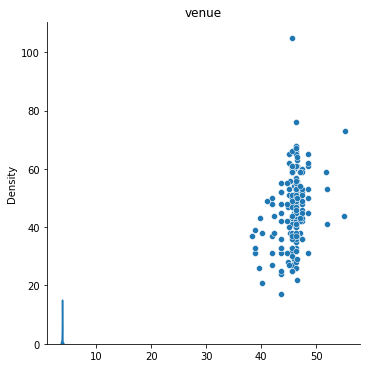

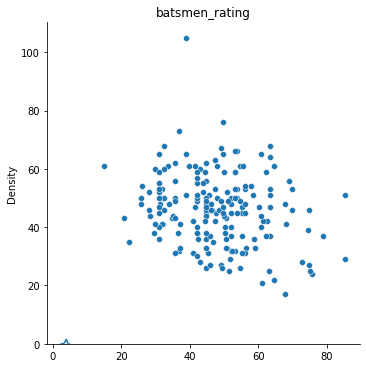

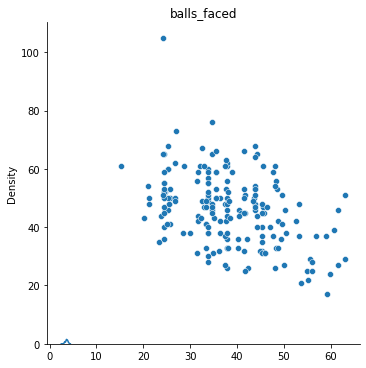

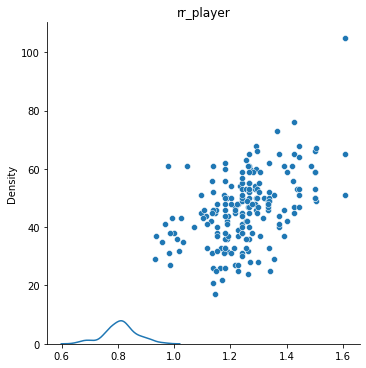

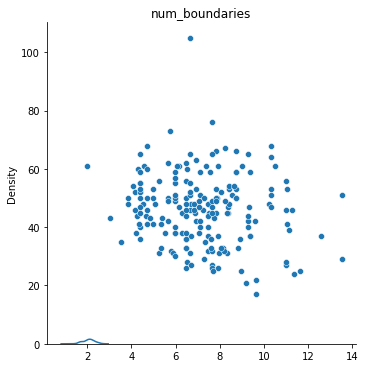

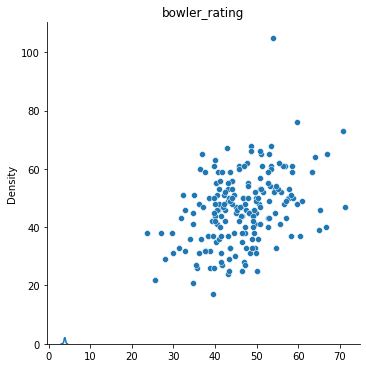

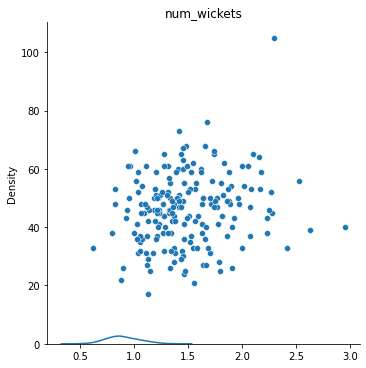

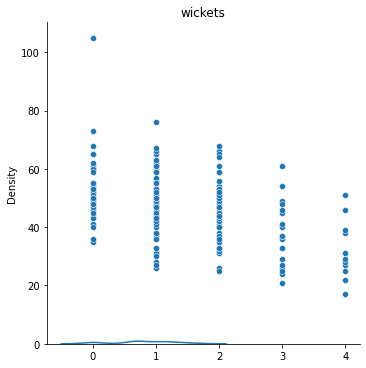

In [8]:
for feature in X.columns:
    sns.relplot(x=X[feature].to_numpy(), y=Y.to_numpy().reshape(1,-1)[0])
    sns.kdeplot(x=np.log1p(X[feature].to_numpy()))
    plt.title(feature)
    

In [844]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, VotingRegressor, StackingRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold


In [845]:
linear = LinearRegression()
bayesian = BayesianRidge(alpha_1= 3.3947835934271864, alpha_2= 3.0272144387040733e-05, fit_intercept = True)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0083, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

models = [('baye', bayesian), ('lasso', lasso), ('enet', ENet), ('linear', linear)]
voting_reg = VotingRegressor(estimators=models)
stacked_reg = StackingRegressor(estimators=models)

In [793]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
space = dict()
space['fit_intercept'] = [True]
space['alpha_1'] = loguniform(1e-06, 100)
space['alpha_2'] = loguniform(1e-06, 100)
search = RandomizedSearchCV(bayesian, space, n_iter=500, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, Y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -92.05411459492103
Best Hyperparameters: {'alpha_1': 3.3947835934271864, 'alpha_2': 3.0272144387040733e-05, 'fit_intercept': True}
C:\Users\rishi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [854]:
def get_predictions(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return np.sqrt(np.abs(scores))

In [855]:
for model in models:
    print(model[0], np.mean(get_predictions(model[1])))

baye 9.460447092957553
lasso 9.609594394586741
enet 9.612741038211714
linear 9.614443401431343


In [832]:
print('model', np.mean(get_predictions(extra_trees)))

model 10.630709021186346


In [833]:
print('stacked-regressor', np.mean(get_predictions(stacked_reg)))

stacked-regressor 9.508724601656214
